<a href="https://colab.research.google.com/github/JumanaWanass/Image-Segmentation-using-K-means/blob/main/Image_Segmentation_using_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation using Clustering methods

In this notebook we aim to test several clustering methods along with their hyper parameters, to analyse the best use cases for each method, along with their success rates.

## 1. Importing Libraries

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import os
import pandas as pd
import cv2
import scipy.io
from scipy.io import loadmat

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from skimage import io
from skimage import exposure
from sklearn.metrics import f1_score, adjusted_mutual_info_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances
from skimage.segmentation import slic, mark_boundaries
from skimage import color
import networkx as nx
from sklearn.neighbors import kneighbors_graph

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from google.colab import drive

## 2. BSDS 500

Berkeley Segmentation Data Set and Benchmarks 500 (BSDS500)
This new dataset is an extension of the BSDS300, where the original 300 images are used for training / validation and 200 fresh images, together with human annotations, are added for testing. Each image was segmented by five different subjects on average

### Visualising the dataset

In [ ]:
def display_images(original_image_path, mat_file_path):
    original_image = cv2.imread(original_image_path)

    data = loadmat(mat_file_path)
    ground_truth = data['groundTruth']

    # Create subplots for original image and its grayscale version
    fig, axs = plt.subplots(7, 2, figsize=(6, 14))
    axs[0, 0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    original_image_grayscale = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    axs[0, 1].imshow(original_image_grayscale, cmap='gray')
    axs[0, 1].set_title('Original Image Grayscale')
    axs[0, 1].axis('off')

    # Display segmented image and its corresponding boundary in subsequent rows
    for i, entry in enumerate(ground_truth[0]):
        segmentation = entry['Segmentation'][0, 0]
        boundaries = entry['Boundaries'][0, 0]

        # Display segmented image
        axs[i + 1, 0].imshow(segmentation, aspect='auto')
        axs[i + 1, 0].set_title(f'Segmentation - Entry {i + 1}')
        axs[i + 1, 0].axis('off')

        # Display boundary
        axs[i + 1, 1].imshow(boundaries, cmap='gray', aspect='auto')
        axs[i + 1, 1].set_title(f'Boundaries - Entry {i + 1}')
        axs[i + 1, 1].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/Dataset'

Mounted at /content/drive


In [ ]:
original_image_path = '/content/drive/MyDrive/Dataset/images/train/22093.jpg'
mat_file_path = '/content/drive/MyDrive/Dataset/ground_truth/train/22093.mat'

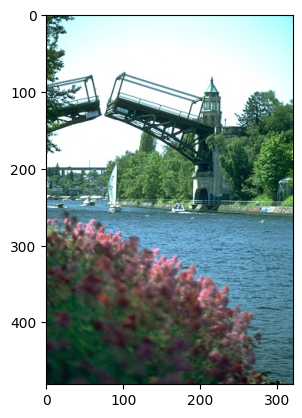

In [ ]:
image = plt.imread(original_image_path)
plt.imshow(image)

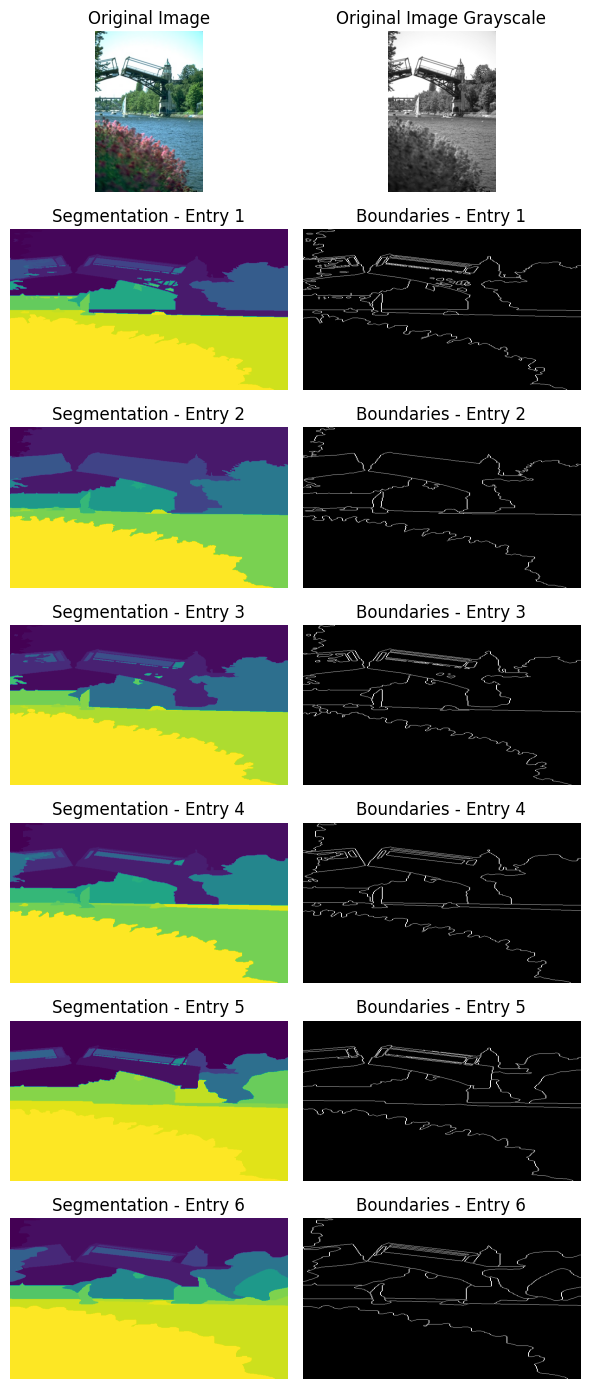

In [ ]:
display_images(original_image_path, mat_file_path)

Testing k means clustering on our sample image

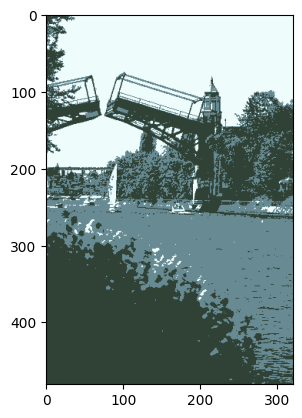

In [ ]:
reshaped = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=3, n_init =10)
kmeans.fit(reshaped)
segmented_image = kmeans.cluster_centers_[kmeans.labels_]
segmented_image = segmented_image.reshape(image.shape)
plt.imshow(segmented_image/255)

## Metrics for evaluation

We will be using conditional entropy along with F1 score for our analysis.

In [ ]:
def evaluate_segmentation(labels, ground_truth_labels):
    f_measure = f1_score(ground_truth_labels.flatten(), labels, average='weighted')
    conditional_entropy = adjusted_mutual_info_score(ground_truth_labels.flatten(), labels)
    return f_measure, conditional_entropy

## K Means Clustering

Image: 22093.jpg, K=5
Shape:  (481, 321, 3)
F-measure: 0.0010987391330063915
Conditional Entropy: 0.4047016448099792



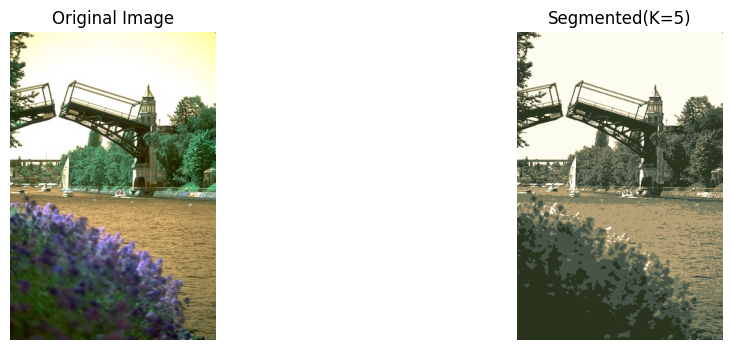

Average F-measure: 0.0010987391330063915
Average Conditional Entropy: 0.4047016448099792
---------------------------------------------------------------------------------------


(0.0010987391330063915, 0.4047016448099792)

In [ ]:
def kmeans_segmentation(image_path, k_values, ground_truth_path):
    image = cv2.imread(image_path)

    pixels = image.reshape((-1, 3))

    #load ground-truth labels
    ground_truth_data = loadmat(ground_truth_path)
    ground_truth_labels = ground_truth_data['groundTruth'][0, 0]['Segmentation'][0, 0]

    #store evaluation results for each K value
    f_measure_list = []
    conditional_entropy_list = []

    #display original image
    plt.figure(figsize=(12, 4))
    plt.subplot(1, len(k_values) + 1, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    for i, k in enumerate(k_values):
        kmeans = KMeans(n_clusters=k, random_state=42)

        labels = kmeans.fit_predict(pixels)
        centers = kmeans.cluster_centers_

        segmented_image = centers[kmeans.labels_].reshape(image.shape)/255.0

        #evaluation
        f_measure, conditional_entropy = evaluate_segmentation(labels, ground_truth_labels)

        #append results to lists
        f_measure_list.append(f_measure)
        conditional_entropy_list.append(conditional_entropy)

        #print evaluation results
        print(f"Image: {os.path.basename(image_path)}, K={k}")
        print("Shape: ",  segmented_image.shape)
        print(f"F-measure: {f_measure}")
        print(f"Conditional Entropy: {conditional_entropy}")
        print("")

        #display segmented images
        plt.subplot(1, len(k_values) + 1, i + 2)
        plt.imshow(segmented_image, vmin=0, vmax=255)
        plt.title(f'Segmented(K={k})')
        plt.axis('off')

    plt.show()

    # Calculate and report average evaluation results
    average_f_measure = sum(f_measure_list) / len(f_measure_list)
    average_conditional_entropy = sum(conditional_entropy_list) / len(conditional_entropy_list)
    print(f"Average F-measure: {average_f_measure}")
    print(f"Average Conditional Entropy: {average_conditional_entropy}")
    print("---------------------------------------------------------------------------------------")
    return average_f_measure, average_conditional_entropy


k_values = [5]
kmeans_segmentation(original_image_path, k_values, mat_file_path)


### K Means with spatial layout

Image: 22093.jpg, K=5 (with spatial layout)
Shape:  (481, 321, 3)
F-measure: 0.00026406065428328097
Conditional Entropy: 0.6209804434651855



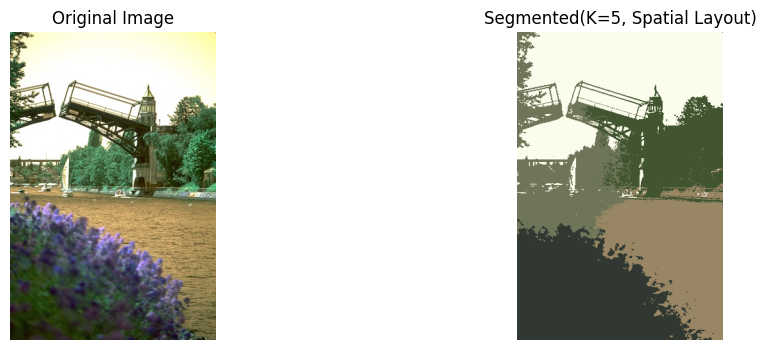

Average F-measure: 0.00026406065428328097
Average Conditional Entropy: 0.6209804434651855
---------------------------------------------------------------------------------------


(0.00026406065428328097, 0.6209804434651855)

In [ ]:
def kmeans_segmentation_with_spatial_layout(image_path, k_values, ground_truth_path):
    image = cv2.imread(image_path)

    # Get image shape for spatial coordinates
    height, width, _ = image.shape

    pixels = image.reshape((-1, 3))

    # Add spatial coordinates to the feature vector
    spatial_coordinates = np.column_stack((np.repeat(np.arange(height), width),
                                           np.tile(np.arange(width), height)))
    pixels_with_spatial = np.column_stack((pixels, spatial_coordinates))

    # Load ground-truth labels
    ground_truth_data = loadmat(ground_truth_path)
    ground_truth_labels = ground_truth_data['groundTruth'][0, 0]['Segmentation'][0, 0]

    # Store evaluation results for each K value
    f_measure_list = []
    conditional_entropy_list = []

    # Display original image
    plt.figure(figsize=(12, 4))
    plt.subplot(1, len(k_values) + 1, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    for i, k in enumerate(k_values):
        kmeans = KMeans(n_clusters=k, random_state=42)

        labels = kmeans.fit_predict(pixels_with_spatial)
        centers = kmeans.cluster_centers_

        # Extract RGB values from the clustered centers
        rgb_centers = centers[:, :3]

        # Create segmented image using clustered centers and spatial layout
        segmented_image = rgb_centers[labels].reshape(image.shape) / 255.0

        # Evaluation
        f_measure, conditional_entropy = evaluate_segmentation(labels, ground_truth_labels)

        # Append results to lists
        f_measure_list.append(f_measure)
        conditional_entropy_list.append(conditional_entropy)

        # Print evaluation results
        print(f"Image: {os.path.basename(image_path)}, K={k} (with spatial layout)")
        print("Shape: ", segmented_image.shape)
        print(f"F-measure: {f_measure}")
        print(f"Conditional Entropy: {conditional_entropy}")
        print("")

        # Display segmented images
        plt.subplot(1, len(k_values) + 1, i + 2)
        plt.imshow(segmented_image, vmin=0, vmax=255)
        plt.title(f'Segmented(K={k}, Spatial Layout)')
        plt.axis('off')

    plt.show()

    # Calculate and report average evaluation results
    average_f_measure = sum(f_measure_list) / len(f_measure_list)
    average_conditional_entropy = sum(conditional_entropy_list) / len(conditional_entropy_list)
    print(f"Average F-measure: {average_f_measure}")
    print(f"Average Conditional Entropy: {average_conditional_entropy}")
    print("---------------------------------------------------------------------------------------")
    return average_f_measure, average_conditional_entropy

k_values = [5]
kmeans_segmentation_with_spatial_layout(original_image_path, k_values, mat_file_path)


## Normalized Cut Clustering

In [ ]:
from skimage import io, segmentation, color, graph
import matplotlib.pyplot as plt
import numpy as np

def normalized_cut_segmentation(image_path, k_values, ground_truth_path):
  image = io.imread(image_path)

  # Load ground-truth labels
  ground_truth_data = loadmat(ground_truth_path)
  ground_truth_labels = ground_truth_data['groundTruth'][0, 0]['Segmentation'][0, 0]

  # Store evaluation results for each K value
  f_measure_list = []
  conditional_entropy_list = []

  # Display original image
  plt.figure(figsize=(12, 4))
  plt.subplot(1, len(k_values) + 1, 1)
  plt.imshow(image)
  plt.title('Original Image')
  plt.axis('off')

  for i, k in enumerate(k_values):
      # Perform SLIC segmentation
      slic_labels = segmentation.slic(image, n_segments=k, compactness=30)

      # Create a Region Adjacency Graph (RAG)
      g = graph.rag_mean_color(image, slic_labels, mode='similarity')

      # Perform Normalized Cut
      normalized_cut_labels = graph.cut_normalized(slic_labels, g)

      # Evaluation
      f_measure, conditional_entropy = evaluate_segmentation(normalized_cut_labels, ground_truth_labels)

      # Append results to lists
      f_measure_list.append(f_measure)
      conditional_entropy_list.append(conditional_entropy)

      # Print evaluation results
      print(f"Image: {os.path.basename(image_path)}, K={k}")
      print(f"F-measure: {f_measure}")
      print(f"Conditional Entropy: {conditional_entropy}")
      print("")

      # Display segmented images
      plt.subplot(1, len(k_values) + 1, i + 2)
      plt.imshow(color.label2rgb(normalized_cut_labels, image, kind='avg'))
      plt.title(f'Normalized-Cut Segmented(K={k})')
      plt.axis('off')

  # Calculate and report average evaluation results
  average_f_measure = sum(f_measure_list) / len(f_measure_list)
  average_conditional_entropy = sum(conditional_entropy_list) / len(conditional_entropy_list)
  print(f"Average F-measure: {average_f_measure}")
  print(f"Average Conditional Entropy: {average_conditional_entropy}")
  print("---------------------------------------------------------------------------------------")

# Example usage:
k_values = [5]
normalized_cut_segmentation(original_image_path, k_values, mat_file_path)


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


KeyboardInterrupt: 

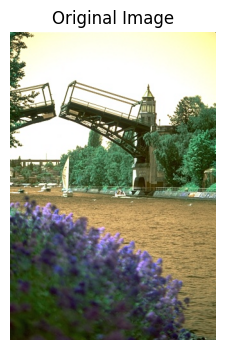

In [ ]:
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import SpectralClustering

def spectral_clustering_segmentation(image_path, k_values, ground_truth_path, subset_size=None):
    image = cv2.imread(image_path)
    pixels = image.reshape((-1, 3))

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=min(3, pixels.shape[0], pixels.shape[1]))  # Adjust the number of components
    pixels_pca = pca.fit_transform(pixels)

    # Load ground-truth labels
    ground_truth_data = loadmat(ground_truth_path)
    ground_truth_labels = ground_truth_data['groundTruth'][0, 0]['Segmentation'][0, 0]

    # Store evaluation results for each K value
    f_measure_list = []
    conditional_entropy_list = []

    # Display original image
    plt.figure(figsize=(12, 4))
    plt.subplot(1, len(k_values) + 1, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    for i, k in enumerate(k_values):
        # Calculate pairwise distances for a subset of pixels
        if subset_size is not None and subset_size < len(pixels_pca):
            subset_indices = np.random.choice(len(pixels_pca), subset_size, replace=False)
            subset_pixels_pca = pixels_pca[subset_indices]
            subset_pairwise_dist = pdist(subset_pixels_pca)  # Calculate distances within the subset
            subset_pairwise_dist_square = squareform(subset_pairwise_dist)  # Convert to square form
            # Map the subset distances to the original distances
            pairwise_dist_sparse = csr_matrix((len(pixels_pca), len(pixels_pca)))  # Initialize a sparse matrix of the correct size
            pairwise_dist_sparse[subset_indices, subset_indices[:, None]] = subset_pairwise_dist_square
            pairwise_dist_sparse[subset_indices[:, None], subset_indices] = subset_pairwise_dist_square.T
        else:
            pairwise_dist = pdist(pixels_pca)
            pairwise_dist_square = squareform(pairwise_dist)
            pairwise_dist_sparse = csr_matrix(pairwise_dist_square)

        # Spectral clustering
        spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
        spectral_labels = spectral.fit_predict(pairwise_dist_sparse)
        spectral_segmented_image = pixels.reshape(image.shape) / 255.0

        # Evaluation
        f_measure, conditional_entropy = evaluate_segmentation(spectral_labels, ground_truth_labels)

        # Append results to lists
        f_measure_list.append(f_measure)
        conditional_entropy_list.append(conditional_entropy)

        # Print evaluation results
        print(f"Image: {os.path.basename(image_path)}, K={k}")
        print("Shape: ", spectral_segmented_image.shape)
        print(f"F-measure: {f_measure}")
        print(f"Conditional Entropy: {conditional_entropy}")
        print("")

        # Display segmented images
        plt.subplot(1, len(k_values) + 1, i + 2)
        plt.imshow(spectral_segmented_image, vmin=0, vmax=255)
        plt.title(f'Spectral Clustering (K={k})')
        plt.axis('off')

        # Close the plot to release memory
        plt.close('all')

    # Calculate and report average evaluation results
    average_f_measure = sum(f_measure_list) / len(f_measure_list)
    average_conditional_entropy = sum(conditional_entropy_list) / len(conditional_entropy_list)
    print(f"Average F-measure: {average_f_measure}")
    print(f"Average Conditional Entropy: {average_conditional_entropy}")
    print("---------------------------------------------------------------------------------------")

# Example usage:
k_values = [5]
spectral_clustering_segmentation(original_image_path, k_values, mat_file_path, subset_size=1000)


In [ ]:
def process_first_50_images(k_values, seg_method):
    test_directory = '/content/drive/MyDrive/Dataset/images/test'
    ground_truth_directory = '/content/drive/MyDrive/Dataset/ground_truth/test'

    average_f_measure_list = []
    average_conditional_entropy_list = []

    count = 0

    for root, dirs, files in os.walk(test_directory):
        for file in files:
            if count >= 5:
                break  # Stop processing after the first 50 images
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file)
                ground_truth_file = os.path.join(ground_truth_directory, file.replace('.jpg', '.mat'))

                if seg_method == "means":
                    avg_f_measure, avg_conditional_entropy = kmeans_segmentation(image_path, k_values, ground_truth_file)
                elif seg_method == "kmeans_segmentation_with_spatial_layout":
                    avg_f_measure, avg_conditional_entropy = kmeans_segmentation_with_spatial_layout(image_path, k_values, ground_truth_file)

                # Append results to lists
                average_f_measure_list.append(avg_f_measure)
                average_conditional_entropy_list.append(avg_conditional_entropy)

                count += 1

    return average_f_measure_list, average_conditional_entropy_list





Image: 100039.jpg, K=3
Shape:  (321, 481, 3)
F-measure: 0.00046783415384260335
Conditional Entropy: 0.1514305771775163

Image: 100039.jpg, K=5
Shape:  (321, 481, 3)
F-measure: 0.0006337026276501562
Conditional Entropy: 0.18367311259508923

Image: 100039.jpg, K=7
Shape:  (321, 481, 3)
F-measure: 0.047779358855607995
Conditional Entropy: 0.17374548542878565

Image: 100039.jpg, K=9
Shape:  (321, 481, 3)
F-measure: 0.07770146960179827
Conditional Entropy: 0.1683091507185552

Image: 100039.jpg, K=11
Shape:  (321, 481, 3)
F-measure: 0.15813243986620287
Conditional Entropy: 0.19955498083994747



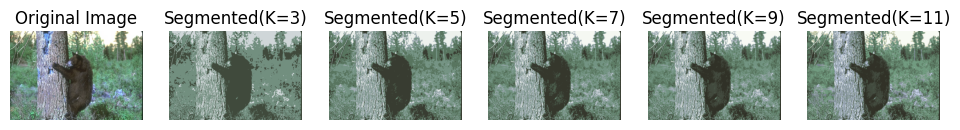

Average F-measure: 0.05694296102102039
Average Conditional Entropy: 0.1753426613519788
---------------------------------------------------------------------------------------
Image: 100007.jpg, K=3
Shape:  (321, 481, 3)
F-measure: 0.19396886768932584
Conditional Entropy: 0.4080287739791004

Image: 100007.jpg, K=5
Shape:  (321, 481, 3)
F-measure: 0.3988346605784189
Conditional Entropy: 0.35689215634747723

Image: 100007.jpg, K=7
Shape:  (321, 481, 3)
F-measure: 0.07586640847240167
Conditional Entropy: 0.4150432757594929

Image: 100007.jpg, K=9
Shape:  (321, 481, 3)
F-measure: 0.06405549938896565
Conditional Entropy: 0.48944183641980654

Image: 100007.jpg, K=11
Shape:  (321, 481, 3)
F-measure: 0.5170765404904482
Conditional Entropy: 0.5157704417324173



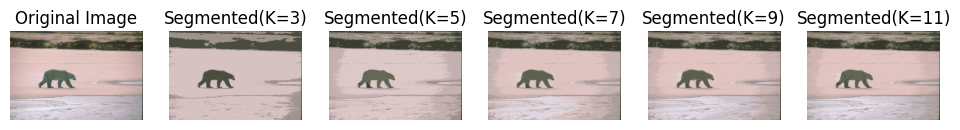

Average F-measure: 0.249960395323912
Average Conditional Entropy: 0.43703529684765885
---------------------------------------------------------------------------------------
Image: 147080.jpg, K=3
Shape:  (321, 481, 3)
F-measure: 0.03636393515058409
Conditional Entropy: 0.2653081210540177

Image: 147080.jpg, K=5
Shape:  (321, 481, 3)
F-measure: 2.01022292374384e-05
Conditional Entropy: 0.35602290947265475

Image: 147080.jpg, K=7
Shape:  (321, 481, 3)
F-measure: 0.06801543209868376
Conditional Entropy: 0.3347605865410439

Image: 147080.jpg, K=9
Shape:  (321, 481, 3)
F-measure: 0.04376639073319266
Conditional Entropy: 0.336266483497128

Image: 147080.jpg, K=11
Shape:  (321, 481, 3)
F-measure: 0.2155897454937141
Conditional Entropy: 0.32785596297554015



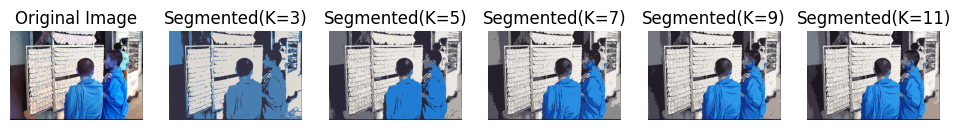

Average F-measure: 0.07275112114108241
Average Conditional Entropy: 0.3240428127080769
---------------------------------------------------------------------------------------
Image: 14092.jpg, K=3
Shape:  (321, 481, 3)
F-measure: 0.3549608706604723
Conditional Entropy: 0.19626435773590317

Image: 14092.jpg, K=5
Shape:  (321, 481, 3)
F-measure: 0.34077038218757094
Conditional Entropy: 0.21034000771502803

Image: 14092.jpg, K=7
Shape:  (321, 481, 3)
F-measure: 0.29135511737744146
Conditional Entropy: 0.20155589144436634

Image: 14092.jpg, K=9
Shape:  (321, 481, 3)
F-measure: 0.24616074166588411
Conditional Entropy: 0.20946696836653142

Image: 14092.jpg, K=11
Shape:  (321, 481, 3)
F-measure: 0.11900048822923323
Conditional Entropy: 0.20368765669035108



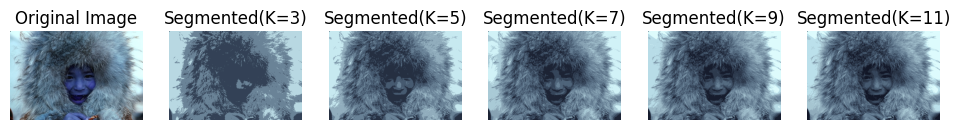

Average F-measure: 0.2704495200241204
Average Conditional Entropy: 0.204262976390436
---------------------------------------------------------------------------------------
Image: 347031.jpg, K=3
Shape:  (481, 321, 3)
F-measure: 0.02848694339845814
Conditional Entropy: 0.4608376006431963

Image: 347031.jpg, K=5
Shape:  (481, 321, 3)
F-measure: 0.0005198507886765043
Conditional Entropy: 0.45909127274766426

Image: 347031.jpg, K=7
Shape:  (481, 321, 3)
F-measure: 0.24412433281743967
Conditional Entropy: 0.4924212069472456

Image: 347031.jpg, K=9
Shape:  (481, 321, 3)
F-measure: 0.11157325402400903
Conditional Entropy: 0.4938566594961516

Image: 347031.jpg, K=11
Shape:  (481, 321, 3)
F-measure: 0.2217198800378891
Conditional Entropy: 0.5017917531759251



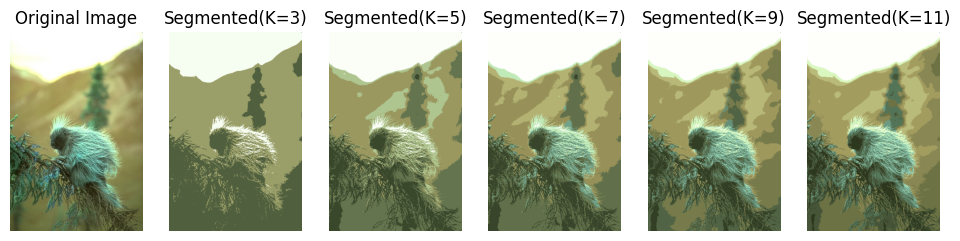

Average F-measure: 0.12128485221329448
Average Conditional Entropy: 0.4815996986020366
---------------------------------------------------------------------------------------
Image: 100039.jpg, K=3 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.0
Conditional Entropy: 0.5676012306072998

Image: 100039.jpg, K=5 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.0010000181998954885
Conditional Entropy: 0.5182995767268023

Image: 100039.jpg, K=7 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.1103957809517236
Conditional Entropy: 0.5253826584361038

Image: 100039.jpg, K=9 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.1508871210346925
Conditional Entropy: 0.499068846249651

Image: 100039.jpg, K=11 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.06326505298693966
Conditional Entropy: 0.4922573721537983



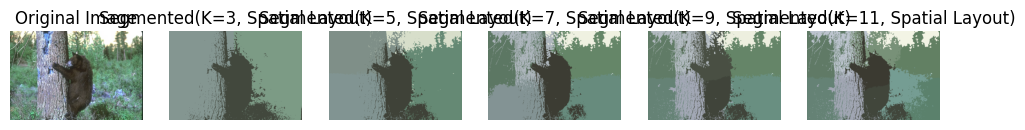

Average F-measure: 0.06510959463465024
Average Conditional Entropy: 0.520521936834731
---------------------------------------------------------------------------------------
Image: 100007.jpg, K=3 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.4502882916850334
Conditional Entropy: 0.4171178310794729

Image: 100007.jpg, K=5 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.010458825522472712
Conditional Entropy: 0.38456830775325296

Image: 100007.jpg, K=7 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.0939188336603633
Conditional Entropy: 0.42408416130419424

Image: 100007.jpg, K=9 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.10862827932093908
Conditional Entropy: 0.4393128533296527

Image: 100007.jpg, K=11 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.005510213746625793
Conditional Entropy: 0.4589540897876782



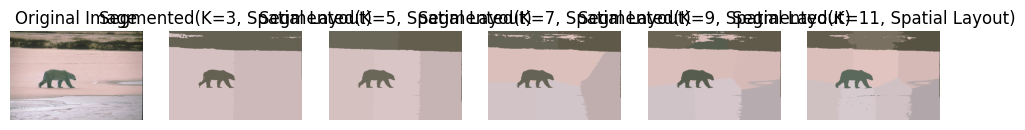

Average F-measure: 0.13376088878708686
Average Conditional Entropy: 0.4248074486508502
---------------------------------------------------------------------------------------
Image: 147080.jpg, K=3 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.32090428257247344
Conditional Entropy: 0.5152764103201708

Image: 147080.jpg, K=5 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.004589061236817654
Conditional Entropy: 0.5540363340742973

Image: 147080.jpg, K=7 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.07229616625059519
Conditional Entropy: 0.5508716332725793

Image: 147080.jpg, K=9 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.2570528857846609
Conditional Entropy: 0.5771477340630553

Image: 147080.jpg, K=11 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.26462876877875763
Conditional Entropy: 0.572397472879295



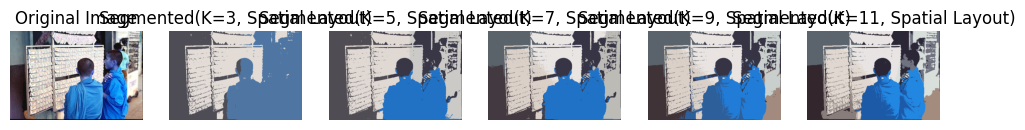

Average F-measure: 0.18389423292466095
Average Conditional Entropy: 0.5539459169218796
---------------------------------------------------------------------------------------
Image: 14092.jpg, K=3 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.3599543998895245
Conditional Entropy: 0.22484789368941746

Image: 14092.jpg, K=5 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.15893741094013777
Conditional Entropy: 0.24232241492062723

Image: 14092.jpg, K=7 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.2766810200158883
Conditional Entropy: 0.32578448704422236

Image: 14092.jpg, K=9 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.23252282559940982
Conditional Entropy: 0.29885191638148395

Image: 14092.jpg, K=11 (with spatial layout)
Shape:  (321, 481, 3)
F-measure: 0.1971654454428002
Conditional Entropy: 0.31912867273450607



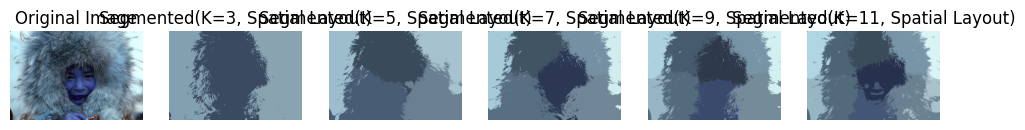

Average F-measure: 0.24505222037755212
Average Conditional Entropy: 0.28218707695405143
---------------------------------------------------------------------------------------
Image: 347031.jpg, K=3 (with spatial layout)
Shape:  (481, 321, 3)
F-measure: 0.21186679380643525
Conditional Entropy: 0.523686965774762

Image: 347031.jpg, K=5 (with spatial layout)
Shape:  (481, 321, 3)
F-measure: 0.19279832053667634
Conditional Entropy: 0.6069967574774806

Image: 347031.jpg, K=7 (with spatial layout)
Shape:  (481, 321, 3)
F-measure: 0.037916718846687424
Conditional Entropy: 0.5952629111506127

Image: 347031.jpg, K=9 (with spatial layout)
Shape:  (481, 321, 3)
F-measure: 0.168433838462157
Conditional Entropy: 0.6439081507172318

Image: 347031.jpg, K=11 (with spatial layout)
Shape:  (481, 321, 3)
F-measure: 0.1462190372499691
Conditional Entropy: 0.641052673821968



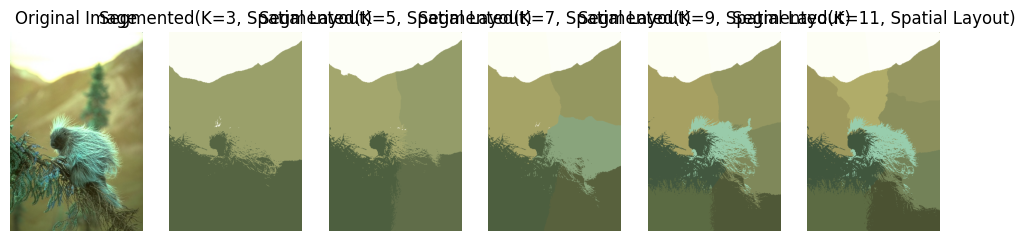

Average F-measure: 0.15144694178038504
Average Conditional Entropy: 0.6021814917884111
---------------------------------------------------------------------------------------


In [ ]:
k_values = [3, 5, 7, 9, 11]
means_f_measure, means_conditional_entropy = process_first_50_images(k_values, "means")
spatial_layout_f_measure, spatial_layout_conditional_entropy = process_first_50_images(k_values, "kmeans_segmentation_with_spatial_layout")



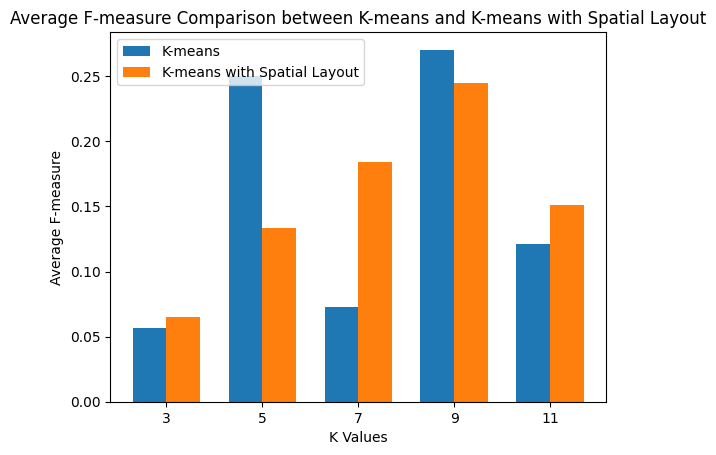

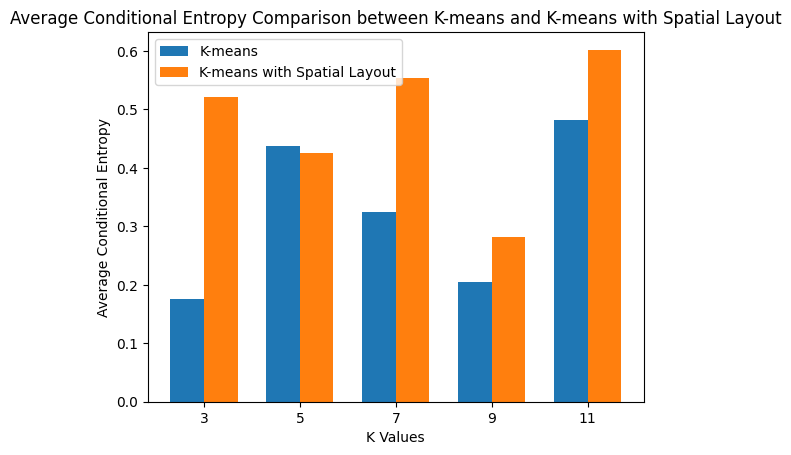

In [ ]:

def create_bar_plot(k_values, means_metric, spatial_layout_metric, metric_name):
    bar_width = 0.35
    index = np.arange(len(k_values))

    plt.bar(index, means_metric, bar_width, label='K-means')
    plt.bar(index + bar_width, spatial_layout_metric, bar_width, label='K-means with Spatial Layout')

    plt.xlabel('K Values')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Comparison between K-means and K-means with Spatial Layout')
    plt.xticks(index + bar_width / 2, k_values)
    plt.legend()

    plt.show()

# Example usage:
k_values = [3, 5, 7, 9, 11]
create_bar_plot(k_values, means_f_measure, spatial_layout_f_measure, 'Average F-measure')
create_bar_plot(k_values, means_conditional_entropy, spatial_layout_conditional_entropy, 'Average Conditional Entropy')
